# GAN - first tries

We are implementing a simple feed-forward GAN architecture on MNIST - just to get the feeling right.

## Loading data

In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np

In [2]:
data = mnist.load_data()
(train_X, train_y),(test_X,test_y) = data

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
# The more the merrier :-)
# Remember, this is unsupervised learning, so "holdout" and such makes less sense
X = np.concatenate((train_X,test_X),axis=0)
y = np.concatenate((train_y,test_y),axis=0)

In [4]:
X.shape

(70000, 28, 28)

In [5]:
y.shape

(70000,)

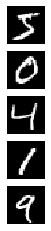

In [18]:
import matplotlib.pyplot as plt

example_count = 5

for ex in range(example_count):
    plt.subplot(5, example_count//5, ex+1)
    plt.imshow(train_X[ex], interpolation="nearest", cmap="gray")
    plt.axis("off")

plt.show()

In [0]:
# Normalization betwenn -1 and 1 !!!!
quasi_mean = X.max()/2 # Max is always 255, so this works ok.
X = (X.astype(np.float32)-quasi_mean)/quasi_mean

In [7]:
# NOT Flattening of the image vectors!!!!
# This is a convolutional model, so it works well with 2D data
# X = X.reshape(X.shape[0],-1)

# Instead, we add a new "channel" axis to the data. 
# Since this is grayscale, that is only 1 channel.

X = X[:,np.newaxis]

X.shape

(70000, 1, 28, 28)

## Parameters

### Training parameters

We will be forced to do manual batching here, so we have to calcculate the number of batches manually, and iterate on a per batch basis.

In [0]:
EPOCHS = 30
BATCH_SIZE = 200
HALF_BATCH = BATCH_SIZE // 2
BATCH_NUM = (X.shape[0] // BATCH_SIZE)
if X.shape[0] % BATCH_SIZE:
    BATCH_NUM+=1
Z_DIM = 100

NUM_CLASSES = 10

### Model parameters

In [0]:
GENERATOR_INITIAL_IMAGE_SIZE = 7
GENERATOR_INITIAL_IMAGE_CHANNELS = 128
GENERATOR_L1_DIM = GENERATOR_INITIAL_IMAGE_SIZE*GENERATOR_INITIAL_IMAGE_SIZE*GENERATOR_INITIAL_IMAGE_CHANNELS 
# eg. 7*7 image, 128 channels it will be, and we go DOWN with the channels from there

# We have to tkae care, that the final shape of all generator convolutions results in 28*28*1, 
# so it is a kind of balancing act
GENERATOR_L2_DIM = 64
GENERATOR_L2_KERNEL_SIZE = (5,5)
GENERATOR_OUTPUT_DIM = 1 # Nuber of output CHANNELS!!!!
GENERATOR_OUTPUT_KERNEL_SIZE = (5,5)

GENERATOR_L3_DIM = 1024

DISCRIMINATOR_L1_DIM = 64
DISCRIMINATOR_L1_KERNEL_SIZE = (5,5)
DISCRIMINATOR_L2_DIM = 128
DISCRIMINATOR_L2_KERNEL_SIZE = (5,5)

LEAKY_ALPHA = 0.2

## Model building

Please remember th ACGAN architecture:

<img src="https://programming.vip/images/doc/7337a1370ac02af82912e32d852fabeb.jpg" width=25%>

Which is convolutional in this case, so DCGAN is relevant here, for the convolutions:

<img src="https://miro.medium.com/max/760/1*B7y91tLgeWE-EuuFP-1XwA.png" width=65%>

As well as the calculation of the resulting image sizes in case of a convolution:

<img src="https://qph.fs.quoracdn.net/main-qimg-d4023fe66cac95238a76ea1b5bc21d84" wudth=45%>

In [0]:
from tensorflow.keras.optimizers import Adam

# Some empirically set values. 
# It might well be worth experimenting with newer optimizers / settings
optimizer = Adam(lr=2e-4, beta_1=0.5)

### Generator

In [0]:
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Conv2D, Flatten, Reshape
from tensorflow.keras.layers import BatchNormalization, UpSampling2D, Embedding, multiply
from tensorflow.keras.models import Model

In [0]:
### Define the generator!
#########################

# We use FUNCTIONAL API!

# The generator always gets a noise vector as input
noise_input = Input(shape=(Z_DIM,))
# AND a real as a single value. (Please observe, even a single value should be an 1 long vector!)
label_input = Input(shape=(1,),dtype='int32')

# Now we have to make sure, that the labels are embedded to a space which has the same dimensions as the noise input
# For this, ve use an embedding, that transforms the class input (which has a range defined in a comnstant above)
# to something, that matches the dimensions of the noise input.
embedded_label_input = Embedding()
# This is a technical step to ensure, it is a vector
embedded_label_input = Flatten()(embedded_label_input)

# And then we simply multiply the noise with the embedded class 
# For this, we already imported the function above.
# Please observe, that the function takes in a LIST of things
combined_input = ....
# Note, other operations can make sense here, it is an empirical thing to try...

# Define the first layer of the fully connected network, without activation!
# Use the parameters defined with capital letter constants in the cells above for node counts!
g_layer_1 = ....

# But we do have to ensure that the input for anything convolutional is 2D + channel, so reshape is in order
# remeber, it is image szie * image size * channels
# ant this is the initial "image"
# USE THE DEFINED CONSTANTS FROM ABOVE, and define a reshape layer!
reshaped_layer = ....

# Define a non-linearity, namely leaky relu on this layer!
# We use LeakyReLU for avoiding sparsity - other options are viable also, just not normal relu
# use the alpha value defined in constants above!
g_layer_1_nonlin = ....

# For stability, we add a batch normalization layer - no extra settings.
g_layer_1_batchnorm = ....

# Now we use Upsampling to gradually get the image resolution up, by doubling
# upsampling layer does this without any extra parameters.
g_layer_2_upsample = ....
# As a result we have 14*14*128 - with the above default settings

# Furthermore we use convolutions to get the number of channels down
# Define a convolutional layer to get down to the layer 2 dimension of generator (number of filters)
# Use the defined constant from above for layer 2 kernel size, and use _"same"_ padding
g_layer_2_conv = ....
# As a result we get 14*14*64 - with the above default settings

# And again a non linearity as above, please...
g_layer_2_nonlin = ....
# And a batch normalization, as above, please...
g_layer_2_batchnorm = ....

# Now we again use Upsampling to gradually get the image resolution up, by doubling
g_layer_3_upsample = ....
# As a result we have 28*28*64 - with the above default settings

# Furthermore we use Conv2D to get the number of channels down
# Define a convolutional layer to get down to the output layer dimension of generator (number of filters)
# Use the defined constant from above for output layer kernel size, and use _"same"_ padding
# USE A NON-LINEARITY TO PROJECT BETWEEN -1 and 1!!! 
# Remember, the images are normalized!
g_output_layer = ....
# As a result we get 28*28*1 - with the above default settings
# And please notice, that we used an activation, so our pixels get between -1 and 1 again
# This should now be indistinguishable from an input image - hopefully

# Please instantiate the model!
generator = ....

# Please remeber, that the loss for the discriminator will be a binary loss, so this applies here also
# Use the appropriate loss measure!
generator.compile(loss=...., optimizer=optimizer)
# Think about this carefully, please!

### Discriminator

In [0]:
### Define the discriminator!
#############################

# We still use FUNCTIONAL API!

# The discriminator always gets original sized images, so 28x28x1 (channel) as inputs
image_input = ....

# Define the first convolutional layer of the discriminator!
# Use the above defined constants for  filter number and kernel size!
# We use strides of 2,2 instead of pooling, which is a sparse operator, and _"same"_ padding
d_layer_1 = ....
# And add a non-linearity, as in the discriminator, please...
d_layer_1_nonlin = ....

# Repet the block again, please!
d_layer_2 = ....
d_layer_2_nonlin = ....

# Please use an appropriate operation 
# to make the output of the previos conv compatible with a fully connected layer!
d_layer_2_flattened = ....

# Please implement ONE OF the output layers of the discriminator!
# One output of the discriminator is a single binary decision, 
# so one use an appropriate activation and dimensionality!
validity = 

# Please implement THE OTHER output layer of the discriminator!
# The other output of the discriminator is the predicted class of the input (+1 for the fake class!!!!)
# Please observe, thisis a multiclass classification! Use appropriate nonlinearity!
predicted_class = ....

# Please instantiate the model!
discriminator = Model(inputs=...., outputs=[....])
# Observe syntax for multi output!!!

# Please remeber, that ONE loss for the discriminator will be a binary loss (validity)
# And the other will be something for the multi-class classification (including +1 class for fake)
# This is NOT one hot encoded class label, so only one kind of builtin lossfunction works here!
# Think and ask, if unsure!
discriminator.compile(loss=[....], optimizer=optimizer)
# Observe syntax for multi output!!!

### Joint model

In [0]:
### Define the GAN itself!
##########################


# STOP!!!!!!
# This is a crucial line, since in the joint model, discriminator will be frozen, so no weight update!
discriminator.trainable = False

....
# Remove this .... if you understand, why the above line is here!

# What is the input for the whole GAN?
# For one, there is noise:
noise_input = ....
# And for two: there is the class label, as a single number (vector)
label_input = ....

# Use the generator as a function on the input!
# Please remeber, there is a list of TWO things that has to go into the generator!
generated_image = ....

# Use the discriminator as a function on the fake images!
validity, target_label = ....
# Observe, that two things come out of the discriminator!

# Instantiate the joint model, appropriate inputS and outputS! (Plural is not an accident! :-)
# Use lists!
joint_model = ....

# Please think about, why need TWO losses!
joint_model.compile(loss=[....], optimizer=optimizer)


## Helper functions for visualization

In [0]:
# Nothing to see here! :-P

from matplotlib import pyplot as plt
import matplotlib.image as mpimg


def get_example_images(epoch, example_count=25, num_classes=10):
    input_noise = np.random.normal(0,1, size=(example_count,Z_DIM))
    input_classes = []
    class_num = 0
    while len(input_classes)<example_count:
        input_classes.append(class_num)
        class_num+=1
        if class_num > num_classes:
            class_num = 0
    input_classes=np.array(input_classes).reshape(-1,1)
    
    generated_images = generator.predict([input_noise,input_classes])
    generated_images = generated_images.reshape(example_count, 28, 28) #,_
    
    plt.figure(figsize = (5, example_count // 5))
    for ex in range(example_count):
        plt.subplot(5, example_count//5, ex+1)
        plt.imshow(generated_images[ex], interpolation="nearest", cmap="gray")
        plt.axis("off")
    plt.tight_layout()
    plt.savefig("ACGAN_example_images_epoch_num_{0}.png".format(epoch))

def show_image_for_epoch(epoch):
    imgname = "ACGAN_example_images_epoch_num_"+str(epoch)+".png"
    img = mpimg.imread(imgname)
    imgplot = plt.imshow(img)
    plt.show()


## Training

Sadly, we can not use simple `fit()`, but have to construct the main training loop ourselves.

In [0]:
# To see some progress, we use tqdm as a progress bar
from tqdm import tqdm

# Since we do NOT use fit
# sadly, we have to do this ourselves manually
history = {"discriminator":[],"generator":[]}

# Main trainign loop
for epoch_num in range(EPOCHS):
    epoch_discriminator_loss = 0
    epoch_generator_loss = 0
    
    for batch in tqdm(range(BATCH_NUM)):
        # We select randomly a half batch amount of real images from MNIST
        # Use Numpy to choose, no replacement!
        # To ensure, that we have image and class PAIRS, and don't mess up, we use a binary mask.
        # Use choice from numpy to generate a mask for the whole dataset length!
        choice_mask = ....
        real_images = X[choice_mask]
        real_labels = y[choice_mask]
        
        
        # We generate a half batch amount of fake images
        # By first generating a half batch worth of Gaussian noise with zero mean, unit variance
        # and appropriate noise dimensions
        input_noise = ....
        
        # And we don't forget to generate the fake labels for them!
        # Which are random integers between 0 and the class number, reshaped to be 1D matrices
        generator_labels = ....
        
        # And then using the fixed generator, to output some images from it
        # Using the predict method of the generator!
        # Warning, the generator needs a list of two things!
        generated_images = ....
        
        ....
        # STOP, and thik through, WHY predict?!
        # Then you can remove the ....
      
        # We generate our "validity" class
        # Remember one sided label smoothing for the positive class!
        # Let's say with 0.9...
        # So please, generate a half batch sized, one dimensional matrix with ones, using numpy
        # and multiuply it by 0.9
        real_validity = ....
        # And generate a half batch worth of zeroes, again one dimensional matrix
        generated_validity = ....

        # And we are making available a vector, with the new "fake" class for the discriminator to find
        # Typically, if we had classes 0-9, we use 10 as the new class label that the discriminator has to find.
        # Happens to be, that NUM_CLASSES is 10 (0-9), so we can use it as the 11th class label
        # Practically: generate a half batch of ones, reshape it to be 1D matrix 
        # and multiply by the number of clases
        labeled_as_fake = 
        
        ### Do the actual training!
        
        # First for the discriminator on the real data
        discriminator_loss_real = discriminator.train_on_batch(real_images, [real_validity, real_labels])
        
        # Then on the fake data
        discriminator_loss_generated = discriminator.train_on_batch(generated_images, [generated_validity, labeled_as_fake])
        
        # We have now two losses for real and two for fake
        # We take the mean of them se two again
        discriminator_loss = 0.5 * (np.array(discriminator_loss_real) + np.array(discriminator_loss_generated))
        epoch_discriminator_loss += np.mean(discriminator_loss)
        
        ### We then update the generator
        # We use the discriminator that was trained a line above, and is frozen, as defined in the joint model
        
        # Please generate a new set of input noise, notice, it is a full batch!
        # Again, using numpy, normal distribution, zero mean, unit variance
        new_input_noise = ....
        
        # And we generate the new random labels for the generator again
        # Between 0 and number of classes, a full batch worth, reshaped as an 1D matrix
        generator_labels = ....
 
        # We try to convince the discriminator, that this is real data - which is not
        # So please generate a batch worth of one dimensional matrix filled with ones 
        convincing_y = .... 
        # Notice, no label smoothing!

        # Remember, the joint model takes in noise plus target labels, 
        # does the generation, the discrimination, whereby outputting validity and a predicted label 
        # (10, if it finds out, that the sample is fake) then computes loss
        # But the discriminator is frozen, so only the generator will get updated
        # It is "successful" if the discriminator predicts "real" - hence the convincing_y
        # and some label differnt from 10 - ideally the one we gave in as input for the generator
        generator_loss = joint_model.train_on_batch([new_input_noise, generator_labels], [convincing_y, generator_labels])
        # Same as above, we take the mean of the losses
        epoch_generator_loss += np.mean(generator_loss)
        
    # Loss printout in every epoch, averaged over the batches
    print("Epoch number:",epoch_num,"discriminator_loss:",epoch_discriminator_loss / BATCH_NUM, "generator_loss:", epoch_generator_loss / BATCH_NUM)
    
    # Save it for the future
    history["discriminator"].append(epoch_discriminator_loss / BATCH_NUM)
    history["generator"].append(epoch_generator_loss / BATCH_NUM)
    
    #Save model - optional
    #generator.save("ACGAN_generator.h5")
    
    #Save images
    get_example_images(epoch_num)
    
    # Show epoch example
    show_image_for_epoch(epoch_num)

## Visualization of training progress

In [0]:
plt.plot(history["discriminator"], color='blue', linewidth=2, label="Discriminator")
plt.plot(history["generator"],  color='red', linewidth=2, label="Generator")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();
